# In-silico perturbation predictions in murine embryos (sci-RNA-seq3)
RegVelo is a generative model coupling cellular dynamics with regulatory networks. For a trained RegVelo model, we can perform in silico counterfactual inference upon perturbations of a TF in the regulatory network. For a trained RegVelo model, we perturb a TF by ignoring all its regulatory effects and generate the perturbed velocity vector field (RegVelo paper Figure 2a; Methods). In this notebook, we will go through the steps of in-silico perturbation of a selected transcription factor (TF) and quantify the perurbation effects on the terminal states.

This tutorial uses a subset of the data from [Qiu, C. et al, 2024](https://doi.org/10.1038/s41586-024-07069-w). 

In this [work](https://doi.org/10.1038/s41586-024-07069-w), the authors profiled 12.4 million nuclei from 83 murine embryos at different stages during gestation (from late gastrulation to birth). The subset used in this tutorial focuses on cells involved in the neural crest development. 

:::{note} For this tutorial, `petsc4py` and `slepc4py` are needed to run [CellRank](https://cellrank.readthedocs.io/en/latest/index.html)'s `estimators.compute_macrostates` using the default method. You can install it with `pip install petsc4py slepc4py`.

## Library import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cellrank as cr
import scanpy as sc
import scvelo as scv
import scvi
from regvelo import REGVELOVI

import regvelo as rgv

import torch

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["svg.fonttype"] = "none"
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Load data
Here, we load the murine neural crest dataset described above. The dataset contains 6788 cells and 1164 genes. Cell-type annotation can be assessed in the `.obs['celltype_update']` layer and includes *Neural crest (PNS glia)*, *Otic sensory neurons*, *Myelinating Schwann cells*, *Neural crest (PNS neurons)*, *Olfactory ensheathing cells*, *Myelinating Schwann cells (Tgfb2+)*, *Dorsal root ganglion neurons*, *Melanocyte cells*, and *Enteric neurons*. The list of TFs can be assessed via `.var['TF']`.

In [6]:
adata_baseline = rgv.datasets.murine_nc(data_type = "preprocessed")

In [7]:
adata_baseline

AnnData object with n_obs × n_vars = 6788 × 1164
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'UMI_count', 'gene_count', 'major_trajectory', 'celltype_update', 'UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_2d_1', 'UMAP_2d_2', 'terminal_state', 'nCount_intron', 'nFeature_intron', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_genes', 'TF'
    uns: 'celltype_update_colors', 'log1p', 'neighbors', 'network', 'regulators', 'skeleton', 'targets', 'terminal_state_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

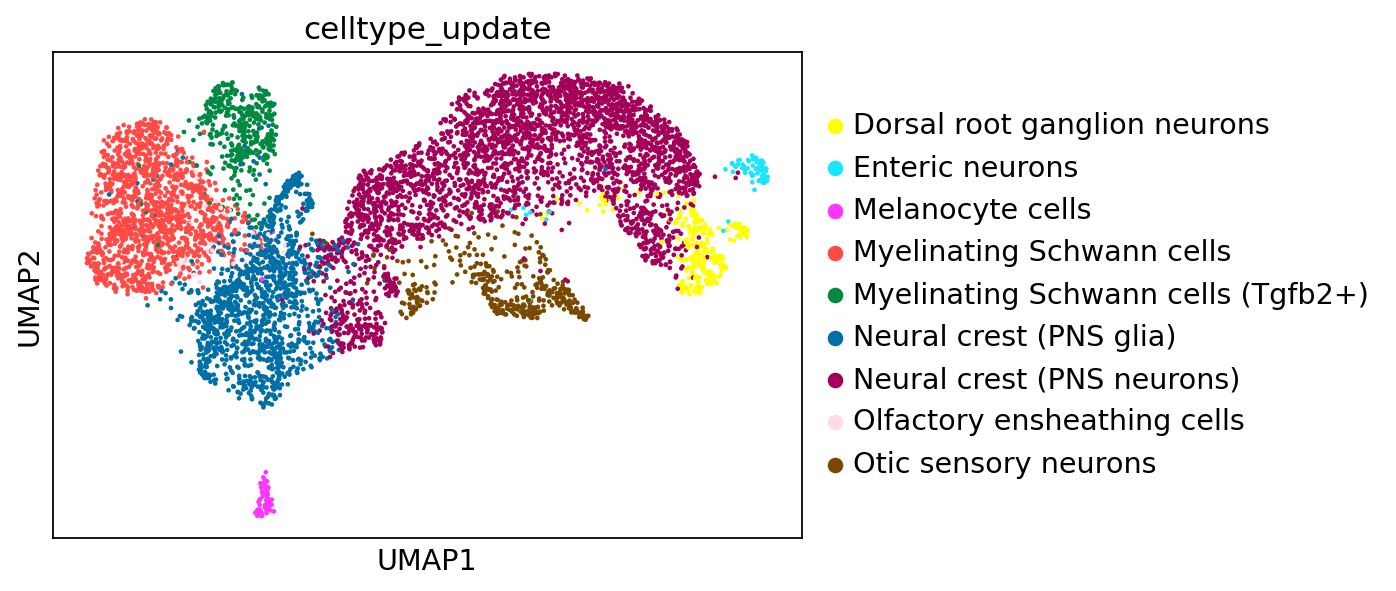

In [8]:
sc.pl.umap(adata_baseline,
           color="celltype_update"
          )

In [9]:
TF = adata_baseline.var_names[adata_baseline.var["TF"]]

## Velocity pipeline
Prior GRN information is inferred using [pySCENIC](https://github.com/aertslab/pySCENIC) and is saved in `.uns['skeleton']`. Note that for the RegVelo pipeline, rows of the prior GRN indicate targets, while columns indiate regulators. 

We save the trained model, as it will later be used in RegVelo's `in_silico_block_simulation` for TF perturbation.

In [10]:
W = adata_baseline.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
W = W.T

In [11]:
REGVELOVI.setup_anndata(adata_baseline, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata_baseline, W=W, regulators=TF)

In [12]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo_env/lib/python3.10/site-packages/lightni

Epoch 1500/1500: 100%|██████████| 1500/1500 [40:50<00:00,  2.30s/it, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [40:50<00:00,  1.63s/it, v_num=1]


In [13]:
vae.save("regvelo_model")

Next, we add the inference results to adata_baseline using `rgv.tl.set_output` function.

In [14]:
rgv.tl.set_output(adata_baseline, vae, n_samples=30, batch_size=adata_baseline.n_obs)

In [15]:
adata_baseline

AnnData object with n_obs × n_vars = 6788 × 1164
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'UMI_count', 'gene_count', 'major_trajectory', 'celltype_update', 'UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_2d_1', 'UMAP_2d_2', 'terminal_state', 'nCount_intron', 'nFeature_intron', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_genes', 'TF', 'fit_beta', 'fit_gamma', 'fit_scaling'
    uns: 'celltype_update_colors', 'log1p', 'neighbors', 'network', 'regulators', 'skeleton', 'targets', 'terminal_state_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity', 'latent_time_velovi', 'fit

## CellRank's cell fate predictions on vector fields inferred from baseline trained RegVelo model
We first define the set of terminal states involving *Dorsal root ganglion neurons*, *Enteric neurons*, *Melanocyte cells*, *Myelinating Schwann cells*, *Myelinating Schwann cells (Tgfb2+)*, and *Otic sensory neurons*. In the following, we use [CellRank](https://www.nature.com/articles/s41592-021-01346-6) to predict cell fate probabilities towards the set of terminal states using the `VelocityKernel` from [CellRank](https://www.nature.com/articles/s41592-021-01346-6).

In [16]:
TERMINAL_STATE = ['Dorsal root ganglion neurons','Enteric neurons',
                  'Melanocyte cells', 'Myelinating Schwann cells',
                  'Myelinating Schwann cells (Tgfb2+)',
                  'Otic sensory neurons']

In [17]:
vk = cr.kernels.VelocityKernel(adata_baseline).compute_transition_matrix()
vk.write_to_adata()

Computing transition matrix using `'deterministic'` model
100%|██████████| 6788/6788 [00:26<00:00, 260.73cell/s] 
Using `softmax_scale=17.1293`
100%|██████████| 6788/6788 [00:03<00:00, 1744.52cell/s]
    Finish (0:00:30)


In [18]:
estimator = cr.estimators.GPCCA(vk)
estimator.compute_macrostates(n_states=10, cluster_key="celltype_update")

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
Computing `10` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:04)


GPCCA[kernel=VelocityKernel[n=6788], initial_states=None, terminal_states=None]

In [19]:
estimator.set_terminal_states(TERMINAL_STATE)
estimator.compute_fate_probabilities(solver = "direct")

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities
Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:04)


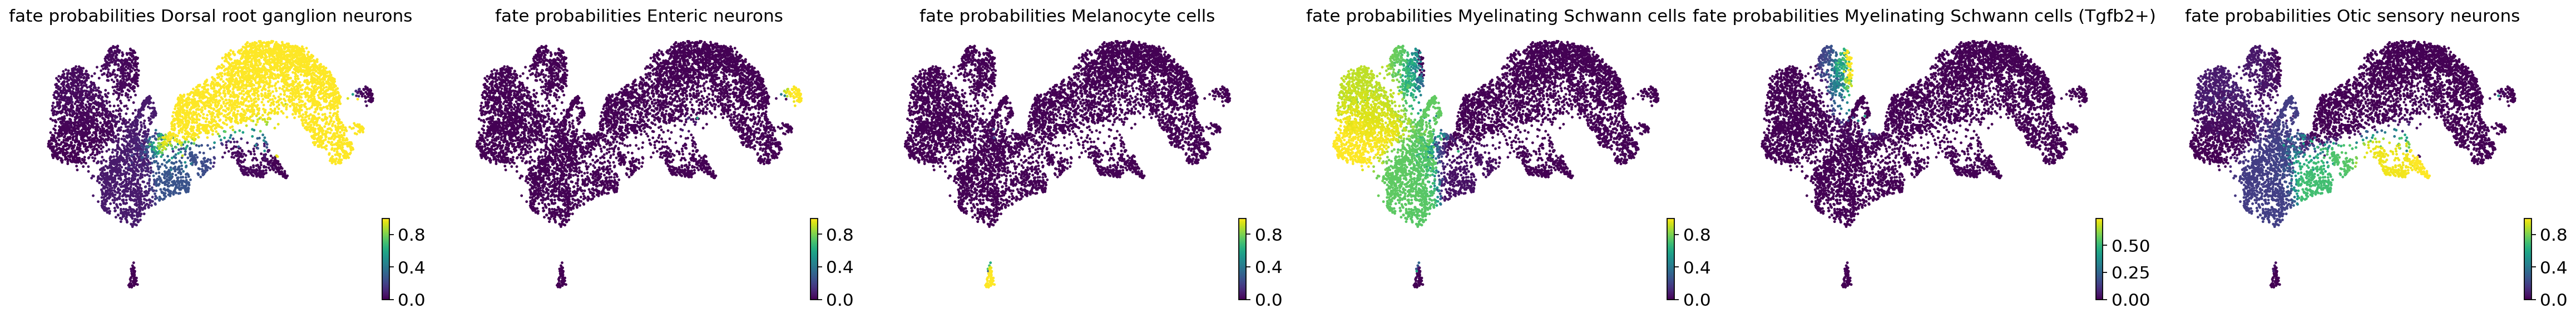

In [20]:
estimator.plot_fate_probabilities(same_plot=False, basis="umap")

For each cell, we further use the function `rgv.pl.commitment_score` to compute and plot its cell fate commitment score, which is defined as the entropy of the cell fate probability distribution, where commited cells have a lower commitment score.

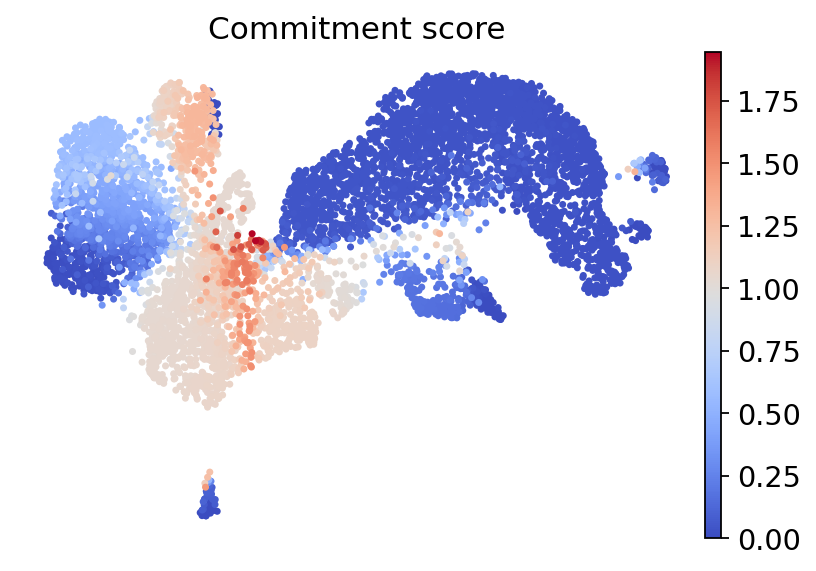

In [21]:
rgv.pl.commitment_score(adata=adata_baseline,
                        lineage_key="lineages_fwd",
                        frameon=False,
                        s=40,
                        cmap="coolwarm",
                        title="Commitment score"
                       )

## Perturb a TF in the regulatory network
In the following, we consider four classical TFs, i.e. *Mitf*, *Sox10*, *Pou4f1*, and *Neurod1*, that are essential in lineage specification during neural crest development. *Mitf* is involved in the development of many cell lineages including melanocyte cells ([Hershey, C.L. and Fisher, D.E., 2004](https://doi.org/10.1016/j.bone.2003.08.014)), the TF *Sox10* plays an important role in differentiation of peripheral glial cells ([Britsch, S. 2001](https://doi.org/10.1101/gad.186601)), *Pou4f1*, also known as *Brn3a*, is particularly involved in the development of retinal ganglin cells and sensory neurons ([Gerrero, M.R. et al, 1993](https://doi.org/10.1073/pnas.90.22.10841)), and *Neurod1* plays an important role in terminal neuronal differntiation ([Boutin, C., 2009](https://doi.org/10.1073/pnas.0909015107)).

In [22]:
TF_candidate = ["Mitf","Sox10","Pou4f1","Neurod1"]

Here, we specify the path to the baseline trained RegVelo model. For each of the TFs in `TF_candidate`, we use RegVelo's `in_silico_block_simulation` function to remove the target TF's regulatory effects of the baseline trained RegVelo model to compute a perturbed velocity field.

In [23]:
MODEL = "regvelo_model"

In [24]:
adata_perturb_dict = {}
for TF in TF_candidate:
    adata_perturb, reg_vae_perturb =  rgv.tl.in_silico_block_simulation(model=MODEL, 
                                                                        adata=adata_baseline, 
                                                                        TF=TF, 
                                                                        cutoff=0)
    adata_perturb_dict[TF] = adata_perturb

INFO     File regvelo_model/model.pt already downloaded                                                            
INFO     File regvelo_model/model.pt already downloaded                                                            
INFO     File regvelo_model/model.pt already downloaded                                                            
INFO     File regvelo_model/model.pt already downloaded                                                            


For each of the TFs, we quantify the perturbation effects on cell fate decisions by passing the perturbed velocity estimates to 
[CellRank](https://www.nature.com/articles/s41592-021-01346-6)'s functions using the `VelocityKernel` in [CellRank](https://www.nature.com/articles/s41592-021-01346-6). In addition, we compute the depletion score for each terminal state using either the $t$-test statistics (`method='t-statistics'`) or the normalized Mann-Whitney $U$ statistics (`method='likelihood'`), which is the default method. We can then plot the depletion scores for each TF for each terminal state using the `rgv.pl.depletion_score` function.

In [25]:
ct_indices = {
    ct: adata_baseline.obs["term_states_fwd"][adata_baseline.obs["term_states_fwd"] == ct].index.tolist()
    for ct in TERMINAL_STATE}

# Computing states transition probability for perturbed systems
for TF, adata_target_perturb in adata_perturb_dict.items():
    vkp = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(vkp)
    estimator.compute_macrostates(n_states=10, cluster_key='celltype_update')
    estimator.set_terminal_states(ct_indices)
    estimator.compute_fate_probabilities(solver="direct")

    adata_perturb_dict[TF] = adata_target_perturb

Computing transition matrix using `'deterministic'` model
100%|██████████| 6788/6788 [00:03<00:00, 1698.40cell/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Using `softmax_scale=17.1455`
100%|██████████| 6788/6788 [00:03<00:00, 1735.10cell/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/relea

In [26]:
df = rgv.mt.cellfate_perturbation(perturbed=adata_perturb_dict, baseline=adata_baseline, terminal_state=TERMINAL_STATE)
df

,Depletion likelihood,p-value,FDR adjusted p-value,Terminal state,TF
0,0.494434,8.693252e-01,1.000000e+00,Dorsal root ganglion neurons,Mitf
1,0.452041,1.000000e+00,1.000000e+00,Enteric neurons,Mitf
2,0.658523,7.365109e-225,4.419065e-224,Melanocyte cells,Mitf
3,0.454590,1.000000e+00,1.000000e+00,Myelinating Schwann cells,Mitf
4,0.476028,9.999993e-01,1.000000e+00,Myelinating Schwann cells (Tgfb2+),Mitf
5,0.505041,1.545146e-01,4.635437e-01,Otic sensory neurons,Mitf
0,0.391604,1.000000e+00,1.000000e+00,Dorsal root ganglion neurons,Sox10
1,0.341692,1.000000e+00,1.000000e+00,Enteric neurons,Sox10
2,0.442346,1.000000e+00,1.000000e+00,Melanocyte cells,Sox10
3,0.705020,0.000000e+00,0.000000e+00,Myelinating Schwann cells,Sox10


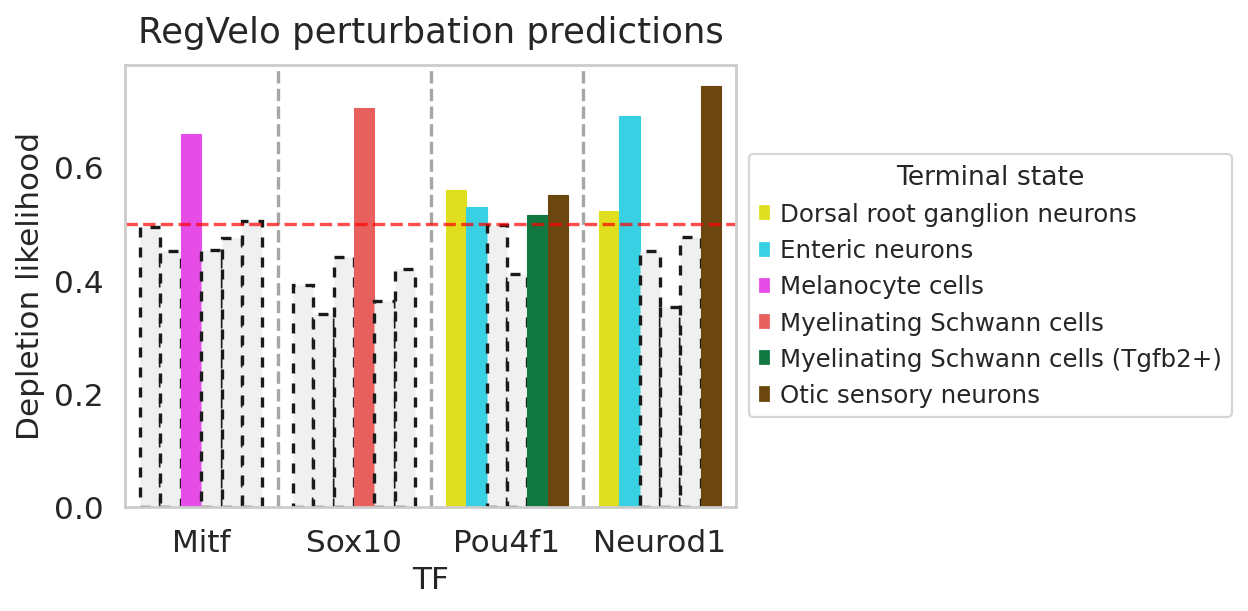

In [27]:
rgv.pl.cellfate_perturbation(adata=adata_baseline,
                             df=df,
                             fontsize=14,
                             figsize=(8, 4),
                             legend_loc='center left',
                             legend_bbox=(1.02, 0.5),
                             color_label="celltype_update")

## Perturbation effect on a single-cell level
To study the perturbation effect of a TF on a single-cell level, we use the `rgv.tl.perturbation_effect` function, which computes the difference of the cell fate probabilities (estimated from perturbed and baseline velocity fields) towards the terminal states for each cell. Negative scores correspond to a decrease in the cell's fate probability towards a selected terminal state. Consider for instance the TF *Neurod1*.

In [28]:
TF = "Neurod1"

In [29]:
adata_perturb = adata_perturb_dict[TF]

In [30]:
adata_baseline = rgv.tl.perturbation_effect(adata_perturb=adata_perturb,
                                            adata=adata_baseline,
                                            terminal_state=TERMINAL_STATE)

The results are saved in `.obs`.

In [31]:
adata_baseline

AnnData object with n_obs × n_vars = 6788 × 1164
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'UMI_count', 'gene_count', 'major_trajectory', 'celltype_update', 'UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_2d_1', 'UMAP_2d_2', 'terminal_state', 'nCount_intron', 'nFeature_intron', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'commitment_score', 'perturbation effect on Dorsal root ganglion neurons', 'perturbation effect on Enteric neurons', 'perturbation effect on Melanocyte cells', 'perturbation effect on Myelinating Schwann cells', 'perturbation effect on Myelinating Schwann cells (Tgfb2+)', 'perturbation effect on Otic sensory neurons'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'gene_count_corr', 'means', 'dispersions', 'dispe

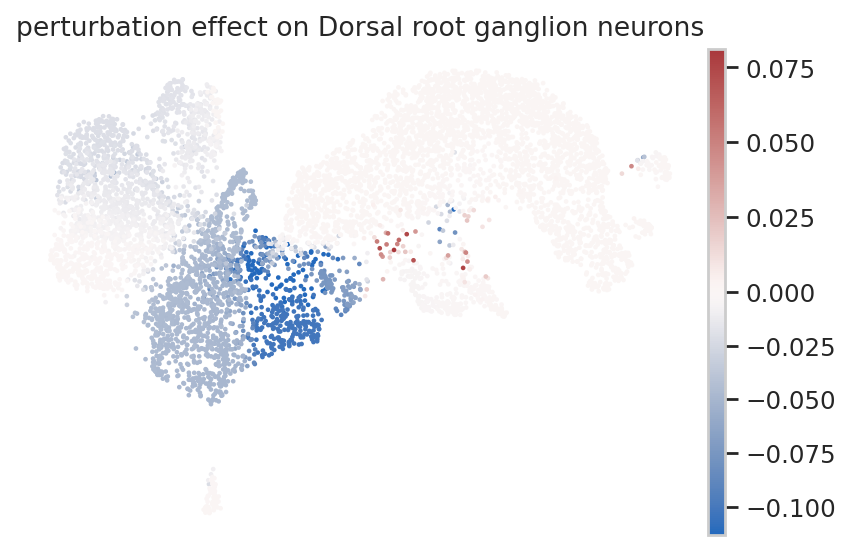

In [32]:
sc.pl.umap(adata_baseline,
           color="perturbation effect on Dorsal root ganglion neurons",
           frameon=False,
           vcenter=0,
           cmap="vlag",
           vmin="p1")

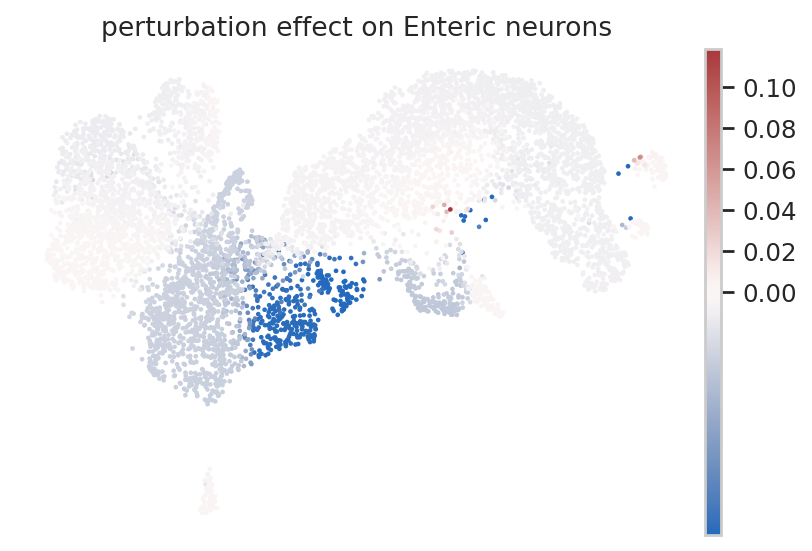

In [33]:
sc.pl.umap(adata_baseline,
           color="perturbation effect on Enteric neurons",
           frameon=False,
           vcenter=0,
           cmap="vlag",
           vmin ="p1")